In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
import folium
from folium import plugins

plt.rcParams['figure.figsize'] = 10,12

import warnings
warnings.filterwarnings('ignore')

In [2]:
#pandemic growth is exponential
#eventually will stop finding people to infect
    #sigmoid curve - in the end will flatten out

In [3]:
confirmed_data = pd.read_csv("time_series_covid19_confirmed_global.csv")
deaths_data = pd.read_csv("time_series_covid19_deaths_global.csv")
recovered_data = pd.read_csv("time_series_covid19_recovered_global.csv")


In [4]:
dates = confirmed_data.columns[4:]


In [5]:
confirmed_data, deaths_data, recovered_data = confirmed_data.melt(
    id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
    value_vars=dates, 
    var_name='Date', 
    value_name='Confirmed'
), deaths_data.melt(
    id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
    value_vars=dates, 
    var_name='Date', 
    value_name='Deaths'
), recovered_data.melt(
    id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
    value_vars=dates, 
    var_name='Date', 
    value_name='Recovered'
)

In [6]:
#merging data together using left join.
covid_data = confirmed_data.merge(
  right=deaths_data, 
  how='left',
  on=['Province/State', 'Country/Region', 'Date', 'Lat', 'Long']
)
covid_data = covid_data.merge(
  right=recovered_data, 
  how='left',
  on=['Province/State', 'Country/Region', 'Date', 'Lat', 'Long']
)

In [7]:
covid_data['Date'] = pd.to_datetime(covid_data['Date'])

In [8]:
covid_data

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered
0,NaN,Afghanistan,33.000000,65.000000,2020-01-22,0,0,0.0
1,NaN,Albania,41.153300,20.168300,2020-01-22,0,0,0.0
2,NaN,Algeria,28.033900,1.659600,2020-01-22,0,0,0.0
3,NaN,Andorra,42.506300,1.521800,2020-01-22,0,0,0.0
4,NaN,Angola,-11.202700,17.873900,2020-01-22,0,0,0.0
5,NaN,Antigua and Barbuda,17.060800,-61.796400,2020-01-22,0,0,0.0
6,NaN,Argentina,-38.416100,-63.616700,2020-01-22,0,0,0.0
7,NaN,Armenia,40.069100,45.038200,2020-01-22,0,0,0.0
8,Australian Capital Territory,Australia,-35.473500,149.012400,2020-01-22,0,0,0.0
9,New South Wales,Australia,-33.868800,151.209300,2020-01-22,0,0,0.0


In [9]:
covid_data['Total cases'] = covid_data['Recovered'] + covid_data['Deaths'] + covid_data['Confirmed']
covid_data['Total Active'] = covid_data['Total cases'] - ( covid_data['Deaths'] + covid_data['Recovered'])

covid_active = covid_data.drop(['Lat', 'Long', 'Confirmed','Deaths','Recovered','Total cases'], axis=1)

# new cases 
temp = covid_data.groupby(['Country/Region', 'Date', ])['Confirmed', 'Deaths', 'Recovered']
temp = temp.sum().diff().reset_index()
mask = temp['Country/Region'] != temp['Country/Region'].shift(1)
temp.loc[mask, 'Confirmed'] = np.nan
temp.loc[mask, 'Deaths'] = np.nan
temp.loc[mask, 'Recovered'] = np.nan
# renaming columns
temp.columns = ['Country/Region', 'Date', 'New cases', 'New deaths', 'New recovered']
# merging new values
covid_data = pd.merge(covid_data, temp, on=['Country/Region', 'Date'])
# filling na with 0
covid_data = covid_data.fillna(0)
# fixing data types
cols = ['New cases', 'New deaths', 'New recovered']
covid_data[cols] = covid_data[cols].astype('int')
# 
covid_data['New cases'] = covid_data['New cases'].apply(lambda x: 0 if x<0 else x)





In [10]:
# Compute days relative to when 100 confirmed cases was crossed
covid_data.loc[:, 'days_since_100'] = np.nan
for Country in covid_data['Country/Region'].unique():
    covid_data.loc[(covid_data['Country/Region'] == Country), 'days_since_100'] = \
        np.arange(-len(covid_data.loc[(covid_data['Country/Region'] == Country) & (covid_data.Confirmed < 100)]), 
                  len(covid_data.loc[(covid_data['Country/Region'] == Country) & (covid_data.Confirmed >= 100)]))

In [11]:
covid_data.head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Total cases,Total Active,New cases,New deaths,New recovered,days_since_100
0,0,Afghanistan,33.0000,65.0000,2020-01-22,0,0,0.0,0.0,0.0,0,0,0,-65.0
1,0,Albania,41.1533,20.1683,2020-01-22,0,0,0.0,0.0,0.0,0,0,0,-61.0
2,0,Algeria,28.0339,1.6596,2020-01-22,0,0,0.0,0.0,0.0,0,0,0,-59.0
3,0,Andorra,42.5063,1.5218,2020-01-22,0,0,0.0,0.0,0.0,0,0,0,-60.0
4,0,Angola,-11.2027,17.8739,2020-01-22,0,0,0.0,0.0,0.0,0,0,0,-131.0


In [12]:

#day by day progression
covid_data_5_31 = covid_data[covid_data['Date']=="5/31/20"]

covid_data_5_31 = covid_data_5_31.groupby(['Date', 'Country/Region',])['Confirmed', 'Deaths', 'Recovered'].sum().reset_index()


In [13]:
covid_data_5_31.style.background_gradient(cmap='Reds')

,Date,Country/Region,Confirmed,Deaths,Recovered
0,2020-05-31 00:00:00,Afghanistan,15205,257,1328
1,2020-05-31 00:00:00,Albania,1137,33,872
2,2020-05-31 00:00:00,Algeria,9394,653,5748
3,2020-05-31 00:00:00,Andorra,764,51,694
4,2020-05-31 00:00:00,Angola,86,4,18
5,2020-05-31 00:00:00,Antigua and Barbuda,26,3,19
6,2020-05-31 00:00:00,Argentina,16851,539,5336
7,2020-05-31 00:00:00,Armenia,9282,131,3386
8,2020-05-31 00:00:00,Australia,7202,103,6618
9,2020-05-31 00:00:00,Austria,16731,668,15593


In [14]:
covid_active_5_31 = covid_active[covid_active['Date']=="5/31/20"]
covid_active_5_31.style.background_gradient(cmap='Reds')
covid_data_5_31 = covid_data_5_31.groupby('Country/Region')


In [15]:
covid_data_5_31.head()

,Date,Country/Region,Confirmed,Deaths,Recovered
0,2020-05-31,Afghanistan,15205,257,1328.0
1,2020-05-31,Albania,1137,33,872.0
2,2020-05-31,Algeria,9394,653,5748.0
3,2020-05-31,Andorra,764,51,694.0
4,2020-05-31,Angola,86,4,18.0
5,2020-05-31,Antigua and Barbuda,26,3,19.0
6,2020-05-31,Argentina,16851,539,5336.0
7,2020-05-31,Armenia,9282,131,3386.0
8,2020-05-31,Australia,7202,103,6618.0
9,2020-05-31,Austria,16731,668,15593.0


In [16]:
map = folium.Map(location=[37,-95],zoom_start=1)

In [17]:
covid_data_5_31 = covid_data[covid_data['Date']=="5/31/20"]


for lat, lon, value, name in zip(covid_data_5_31['Lat'], covid_data_5_31['Long'], covid_data_5_31['Total cases'], covid_data_5_31['Country/Region']):
    
    folium.CircleMarker(location=[lat,lon], radius=value*.000008, popup = name).add_to(map)
    
    
    
map 

In [18]:
covid_data = covid_data[covid_data['Country/Region']!="Canada"]
covid_data = covid_data[covid_data['Country/Region']!="China"]

ship_rows = covid_data['Province/State'].str.contains('Grand Princess') | covid_data['Province/State'].str.contains('Diamond Princess') | covid_data['Country/Region'].str.contains('Diamond Princess') | covid_data['Country/Region'].str.contains('MS Zaandam')
full_ship = covid_data[ship_rows]

covid_data = covid_data[~(ship_rows)]


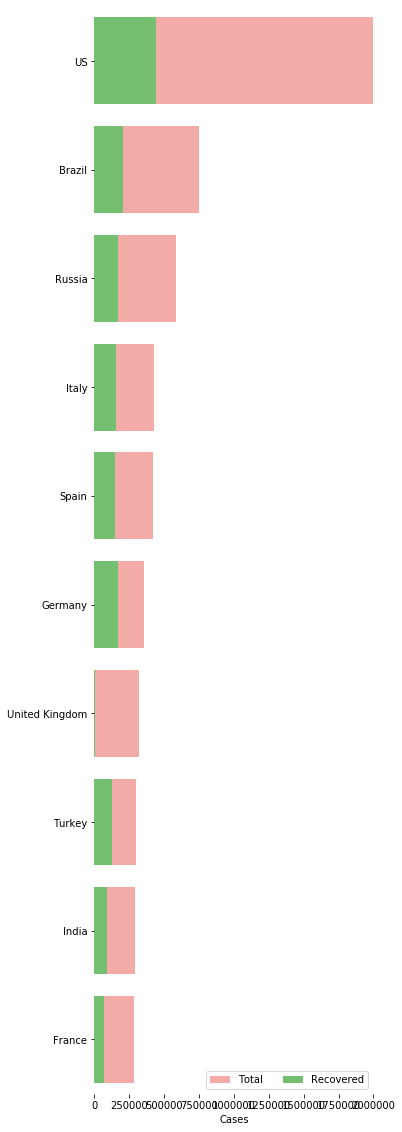

In [19]:
covid_data_5_31 = covid_data_5_31.groupby(['Date', 'Country/Region',])['Confirmed', 'Deaths', 'Recovered','Total cases'].sum().reset_index()

f, ax = plt.subplots(figsize=(5,20))
data = covid_data_5_31[['Country/Region','Total cases','Recovered','Deaths']]
data = covid_data_5_31.nlargest(10, 'Total cases')
data.sort_values('Total cases', ascending=False,inplace=True)
sns.set_color_codes("pastel")
sns.barplot(x="Total cases", y="Country/Region", data=data, label="Total", color="r")

sns.set_color_codes("muted")
sns.barplot(x="Recovered", y="Country/Region", data=data, label="Recovered", color="g")

#legend
ax.legend(ncol=2,loc="lower right", frameon=True)
ax.set(xlim=(0,2000000), ylabel="",xlabel="Cases")
sns.despine(left=True, bottom=True)

In [20]:
covid_data.head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Total cases,Total Active,New cases,New deaths,New recovered,days_since_100
0,0,Afghanistan,33.0000,65.0000,2020-01-22,0,0,0.0,0.0,0.0,0,0,0,-65.0
1,0,Albania,41.1533,20.1683,2020-01-22,0,0,0.0,0.0,0.0,0,0,0,-61.0
2,0,Algeria,28.0339,1.6596,2020-01-22,0,0,0.0,0.0,0.0,0,0,0,-59.0
3,0,Andorra,42.5063,1.5218,2020-01-22,0,0,0.0,0.0,0.0,0,0,0,-60.0
4,0,Angola,-11.2027,17.8739,2020-01-22,0,0,0.0,0.0,0.0,0,0,0,-131.0


In [21]:
covid_data = covid_data.groupby(['Date', 'Country/Region',])['Confirmed', 'Deaths', 'Recovered','Total cases','Total Active','New cases','New deaths','New recovered','days_since_100'].sum().reset_index()


US = covid_data[covid_data['Country/Region']=="US"]
US.name = "0"
Italy = covid_data[covid_data['Country/Region']=="Italy"]
Italy.name = "1"
Brazil = covid_data[covid_data['Country/Region']=="Brazil"]
Brazil.name = "2"
Russia = covid_data[covid_data['Country/Region']=="Russia"]
Russia.name = "3"
Spain = covid_data[covid_data['Country/Region']=="Spain"]
Spain.name = "4"
S_Korea = covid_data[covid_data['Country/Region']=="Korea, South"]
S_Korea.name = "5"
Japan = covid_data[covid_data['Country/Region']=="Japan"]
Japan.name = "6"
India = covid_data[covid_data['Country/Region']=="India"]
India.name = "7"

In [22]:
Brazil.head()

,Date,Country/Region,Confirmed,Deaths,Recovered,Total cases,Total Active,New cases,New deaths,New recovered,days_since_100
23,2020-01-22,Brazil,0,0,0.0,0.0,0.0,0,0,0,-51.0
207,2020-01-23,Brazil,0,0,0.0,0.0,0.0,0,0,0,-50.0
391,2020-01-24,Brazil,0,0,0.0,0.0,0.0,0,0,0,-49.0
575,2020-01-25,Brazil,0,0,0.0,0.0,0.0,0,0,0,-48.0
759,2020-01-26,Brazil,0,0,0.0,0.0,0.0,0,0,0,-47.0


In [40]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=US['Date'], y=US['Total cases'], mode='lines+markers',name='Total Cases'))
fig.update_layout(title_text='Trend of COVID-19 Cases in the US.', plot_bgcolor='rgb(230,230,230)')
fig.show()
fig.write_html('Trend of COVID-19 Cases in the US.html', auto_open=True)

#opens an html



In [41]:
import plotly.express as px
fig = px.bar(US, x="Date", y="New cases", barmode='group', height=400)
fig.update_layout(title_text='COVID-19 New Cases in the US on a daily basis', plot_bgcolor='rgb(230,230,230)')
fig.show()
fig.write_html('COVID-19 New Cases in the US on a daily basis.html', auto_open=True)

#opens an html

In [42]:
#case comparison of countries

'''Countries:

plotly colors

https://plot.ly/python/builtin-colorscales/

US = covid_data[covid_data['Country/Region']=="US"]
Italy = covid_data[covid_data['Country/Region']=="Italy"]
Brazil = covid_data[covid_data['Country/Region']=="Brazil"] 
Russia = covid_data[covid_data['Country/Region']=="Russia"]
Spain = covid_data[covid_data['Country/Region']=="Spain"]
S_Korea = covid_data[covid_data['Country/Region']=="Korea, South"]
Japan = covid_data[covid_data['Country/Region']=="Japan"]
India

#US
fig = px.bar(US, x="Date", y="Total cases", color ='Total cases', orientation='v', height=600,
            title='Confirmed Cases in the US',color_discrete_sequence = px.colors.cyclical.IceFire)

'''

from plotly.subplots import make_subplots

fig = make_subplots(
    rows=3, cols=3,
    subplot_titles=("US","Italy","Brazil","Russia","Spain","S_Korea","Japan","India"))

countries = [US, Italy, Brazil, Russia, Spain, S_Korea, Japan, India]

fig.add_trace(go.Bar(x=US['Date'], y=US['Total cases'],
                    marker=dict(color=US['Total cases'], coloraxis="coloraxis")),1,1)

fig.add_trace(go.Bar(x=Italy['Date'], y=Italy['Total cases'],
                    marker=dict(color=Italy['Total cases'], coloraxis="coloraxis")),1,2)

fig.add_trace(go.Bar(x=Brazil['Date'], y=Brazil['Total cases'],
                    marker=dict(color=Brazil['Total cases'], coloraxis="coloraxis")),1,3)

fig.add_trace(go.Bar(x=Russia['Date'], y=Russia['Total cases'],
                    marker=dict(color=Russia['Total cases'], coloraxis="coloraxis")),2,1)

fig.add_trace(go.Bar(x=Spain['Date'], y=Spain['Total cases'],
                    marker=dict(color=Spain['Total cases'], coloraxis="coloraxis")),2,2)

fig.add_trace(go.Bar(x=S_Korea['Date'], y=S_Korea['Total cases'],
                    marker=dict(color=S_Korea['Total cases'], coloraxis="coloraxis")),2,3)

fig.add_trace(go.Bar(x=Japan['Date'], y=Japan['Total cases'],
                    marker=dict(color=Japan['Total cases'], coloraxis="coloraxis")),3,1)

fig.add_trace(go.Bar(x=India['Date'], y=India['Total cases'],
                    marker=dict(color=India['Total cases'], coloraxis="coloraxis")),3,2)

fig.update_layout(coloraxis=dict(colorscale='Bluered_r'), showlegend=True,title_text="Total Confirmed Cases",plot_bgcolor='rgb(230,230,230)')

fig.show()
fig.write_html('Total Confirmed Cases.html', auto_open=True)

#opens an html

In [43]:
#trend after crossing 100 cases

title = 'Main Source for News'
labels = ["US","Italy","Brazil","Russia","Spain","S_Korea","Japan","India"]
colors = ['rgb(122,128,0)', 'rgb(255,0,0)', 'rgb(49,130,189)','rgb(100,50,0)', 'rgb(100,0,0)', 'rgb(100,130,189)','rgb(200,128,0)', 'rgb(255,100,0)']

mode_size = [10,10,12]
line_size = [2,2,2,2,2,2,2,2]

fig = go.Figure()

countries = [US, Italy, Brazil, Russia, Spain, S_Korea, Japan, India]


for i in countries:
    fig.add_trace(go.Scatter(x=i['days_since_100'],
                         y=i['Total cases'], 
                         mode='lines', 
                         name=labels[int(i.name)],
                         line=dict(color=colors[int(i.name)], width=line_size[int(i.name)]),
                         connectgaps=True))

    
annotations=[]
    
annotations.append(dict(xref='paper', yref='paper', x=0.5, y=-0.1,
                       xanchor='center', yanchor='top',
                       text='Days after crossing 100 cases',
                       font=dict(family='Arial',
                                size=12,
                                color='rgb(150,150,150)'),
                       showarrow=False))

fig.update_layout(annotations=annotations,plot_bgcolor='white',yaxis_title='Cumulative cases')
    
fig.show()
fig.write_html('Cumulative cases.html', auto_open=True)

#opens an html


In [27]:
#build dataframes for confirmed, deaths and recovered to plot the world trend

confirmed = US.groupby('Date').sum()['Confirmed'].reset_index()
deaths = US.groupby('Date').sum()['Deaths'].reset_index()
recovered = US.groupby('Date').sum()['Recovered'].reset_index()

In [44]:
#world trend

fig = go.Figure()

fig.add_trace(go.Scatter(x=confirmed['Date'], y=confirmed['Confirmed'], mode='lines+markers',name='Confirmed',line=dict(color='Blue'),connectgaps=True))
fig.add_trace(go.Scatter(x=deaths['Date'], y=deaths['Deaths'], mode='lines+markers',name='Deaths',line=dict(color='Red'),connectgaps=True))
fig.add_trace(go.Scatter(x=recovered['Date'], y=recovered['Recovered'], mode='lines+markers',name='Recovered',line=dict(color='Green'),connectgaps=True))
fig.update_layout(title='COVID-19 Cases in the US', xaxis_tickfont_size=14,yaxis=dict(title='Number of Cases'))


fig.show()
fig.write_html('COVID-19 Cases in the US.html', auto_open=True)

#opens an html


In [30]:
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation


#fit confirmed data, cross validation -- takes a long time

confirmed.columns =['ds','y']
m = Prophet(mcmc_samples=300, growth='linear', interval_width=0.95)
m.fit(confirmed, control={'max_treedepth': 20})
 
# Compute cross-validation y and yhat for the range of horizons in the figure
df_cv_c= pd.DataFrame()
for h in [10, 20, 30, 40]:
    df_cv_h = cross_validation(m, horizon=pd.to_timedelta(h,unit="D"), period='1 days', initial=pd.to_timedelta(80,unit="D"))
    df_cv_h['horizon'] = h
    df_cv_c = pd.concat((df_cv_c, df_cv_h))

# Compute absolute percent error for each prediction
df_cv_c['mape'] = np.abs((df_cv_c['y'] - df_cv_c['yhat']) / df_cv_c['y'])
# mean absolute percent error, by horizon
mape = df_cv_c.groupby('horizon', as_index=False).aggregate({'mape': 'mean'})
mape


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 41 forecasts with cutoffs between 2020-04-11 00:00:00 and 2020-05-21 00:00:00
INFO:fbprophet:Making 31 forecasts with cutoffs between 2020-04-11 00:00:00 and 2020-05-11 00:00:00
INFO:fbprophet:Making 21 forecasts with cutoffs between 2020-04-11 00:00:00 and 2020-05-01 00:00:00
INFO:fbprophet:Making 11 forecasts with cutoffs between 2020-04-11 00:00:00 and 2020-04-21 00:00:00


,horizon,mape
0,10,0.018845
1,20,0.030004
2,30,0.037837
3,40,0.043158


In [31]:
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

df_p_c = performance_metrics(df_cv_c)
df_p_c.head()



,horizon,mse,rmse,mae,mape,mdape,coverage
0,3 days,2.238186e+08,14960.566816,11708.024911,0.011243,0.010451,0.442125
1,4 days,2.994228e+08,17303.838498,13857.041172,0.012843,0.011709,0.504121
2,5 days,3.981099e+08,19952.692049,16295.361313,0.014696,0.012224,0.599542
3,6 days,5.255548e+08,22924.980976,18901.981366,0.016584,0.013603,0.648168
4,7 days,6.778687e+08,26035.911747,21543.760744,0.018336,0.014794,0.663278


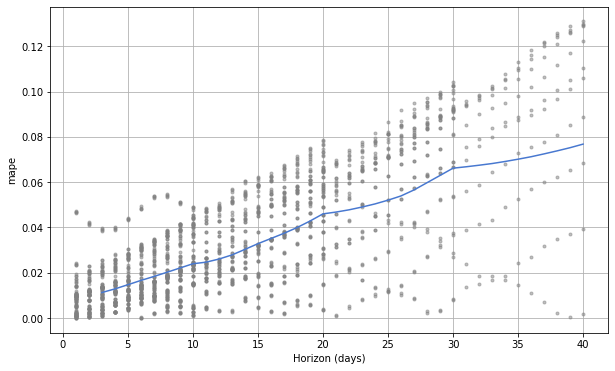

In [33]:
fig_c = plot_cross_validation_metric(df_cv_c, metric='mape')

In [34]:
future_c_7 = m.make_future_dataframe(periods=7)
forecast_c_7 = m.predict(future_c_7)
forecast_c_7 [['ds','yhat','yhat_lower','yhat_upper']].tail()

future_c_14 = m.make_future_dataframe(periods=14)
forecast_c_14  = m.predict(future_c_14)
forecast_c_14[['ds','yhat','yhat_lower','yhat_upper']].tail()

future_c_21 = m.make_future_dataframe(periods=21)
forecast_c_21  = m.predict(future_c_21)
forecast_c_21[['ds','yhat','yhat_lower','yhat_upper']].tail()

future_c_28 = m.make_future_dataframe(periods=28)
forecast_c_28  = m.predict(future_c_28)
forecast_c_28[['ds','yhat','yhat_lower','yhat_upper']].tail()



,ds,yhat,yhat_lower,yhat_upper
154,2020-06-24,2.333000e+06,2.165409e+06,2.489758e+06
155,2020-06-25,2.356675e+06,2.178026e+06,2.523782e+06
156,2020-06-26,2.380948e+06,2.196750e+06,2.556912e+06
157,2020-06-27,2.404370e+06,2.212172e+06,2.588690e+06
158,2020-06-28,2.425268e+06,2.222071e+06,2.616305e+06


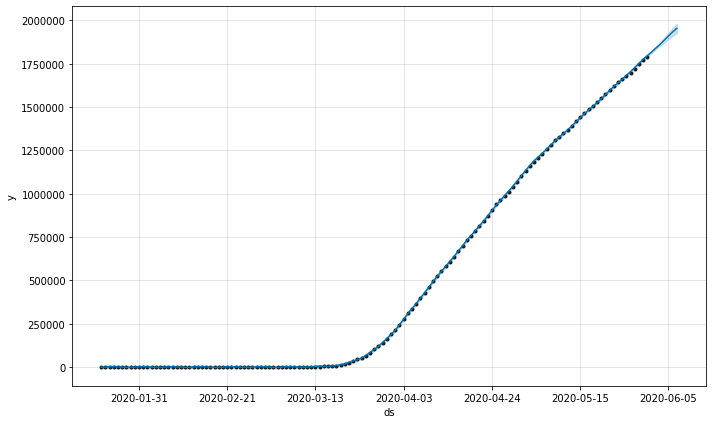

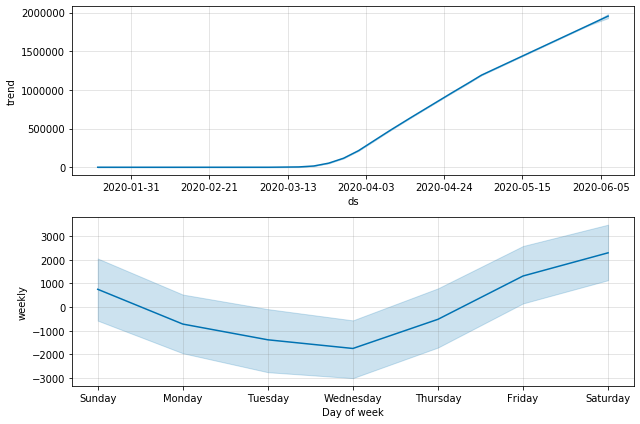

In [35]:
confirmed_forecast_plot = m.plot(forecast_c_7)
confirmed_forecast_plot = m.plot_components(forecast_c_7)

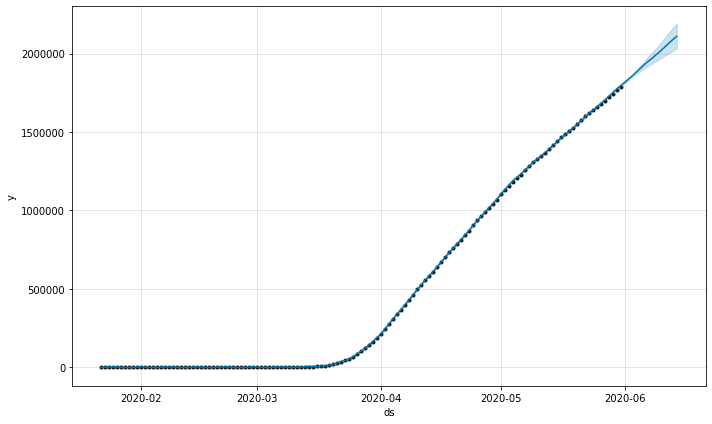

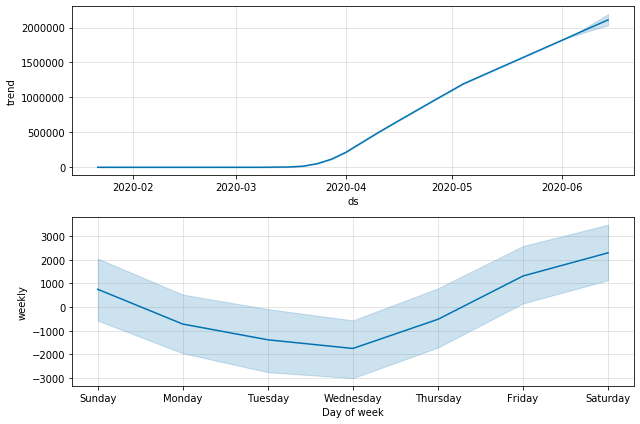

In [36]:
confirmed_forecast_plot = m.plot(forecast_c_14)
confirmed_forecast_plot = m.plot_components(forecast_c_14)

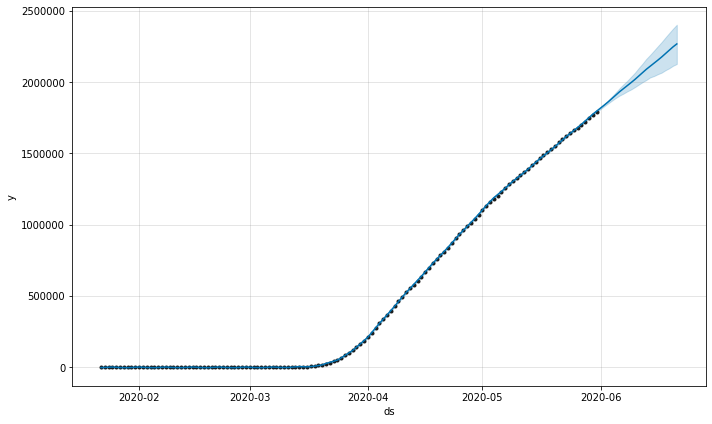

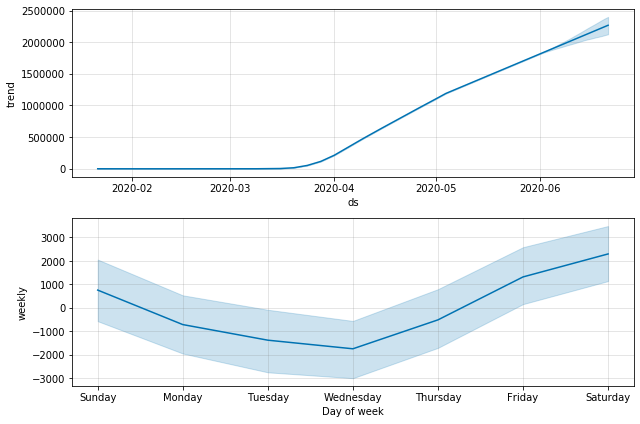

In [37]:
confirmed_forecast_plot = m.plot(forecast_c_21)
confirmed_forecast_plot = m.plot_components(forecast_c_21)

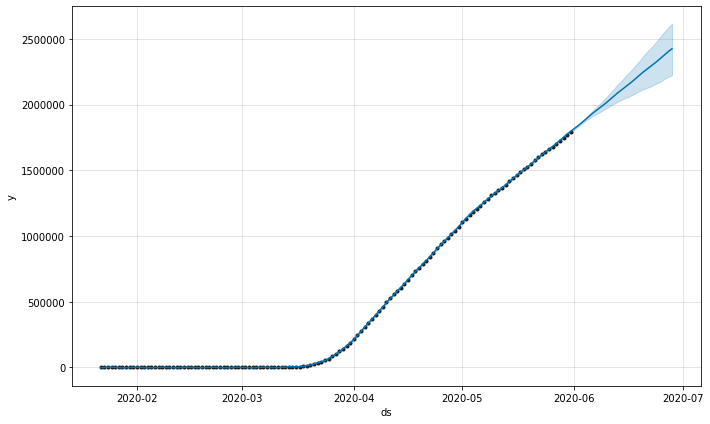

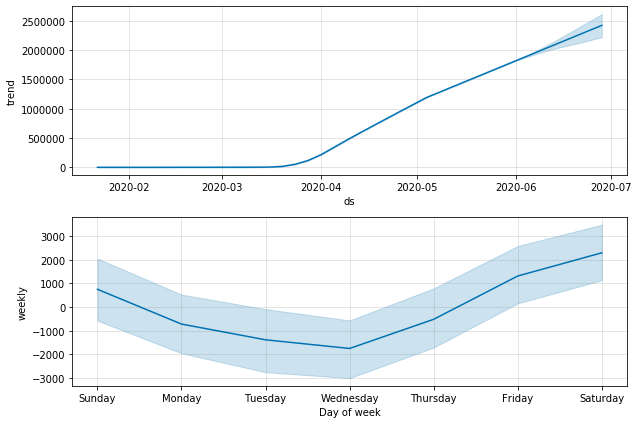

In [38]:
confirmed_forecast_plot = m.plot(forecast_c_28)
confirmed_forecast_plot = m.plot_components(forecast_c_28)

In [39]:
#fit deaths data, cross validation -- takes a long time

deaths.columns =['ds','y']
m = Prophet(mcmc_samples=300, growth='linear', interval_width=0.95)
m.fit(confirmed, control={'max_treedepth': 20})

# Compute cross-validation y and yhat for the range of horizons in the figure
df_cv_d = pd.DataFrame()
for h in [10, 20, 30, 40]:
    df_cv_h = cross_validation(m, horizon=pd.to_timedelta(h,unit="D"), period='1 days', initial=pd.to_timedelta(80,unit="D"))
    df_cv_h['horizon'] = h
    df_cv_d = pd.concat((df_cv_d, df_cv_h))

# Compute absolute percent error for each prediction
df_cv_d['mape'] = np.abs((df_cv_d['y'] - df_cv_d['yhat']) / df_cv_d['y'])
# mean absolute percent error, by horizon
mape = df_cv_d.groupby('horizon', as_index=False).aggregate({'mape': 'mean'})
mape


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 41 forecasts with cutoffs between 2020-04-11 00:00:00 and 2020-05-21 00:00:00
INFO:fbprophet:Making 31 forecasts with cutoffs between 2020-04-11 00:00:00 and 2020-05-11 00:00:00
INFO:fbprophet:Making 21 forecasts with cutoffs between 2020-04-11 00:00:00 and 2020-05-01 00:00:00
INFO:fbprophet:Making 11 forecasts with cutoffs between 2020-04-11 00:00:00 and 2020-04-21 00:00:00


,horizon,mape
0,10,0.018864
1,20,0.029999
2,30,0.037795
3,40,0.043154


In [40]:
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

df_p_d = performance_metrics(df_cv_d)
df_p_d.head()



,horizon,mse,rmse,mae,mape,mdape,coverage
0,3 days,2.237574e+08,14958.521065,11704.820635,0.011237,0.010435,0.437454
1,4 days,2.990945e+08,17294.347870,13850.513231,0.012833,0.011706,0.480311
2,5 days,3.974482e+08,19936.103023,16283.578128,0.014680,0.012198,0.585165
3,6 days,5.251658e+08,22916.495979,18899.446334,0.016579,0.013682,0.652564
4,7 days,6.774517e+08,26027.901638,21545.534927,0.018338,0.014768,0.663370


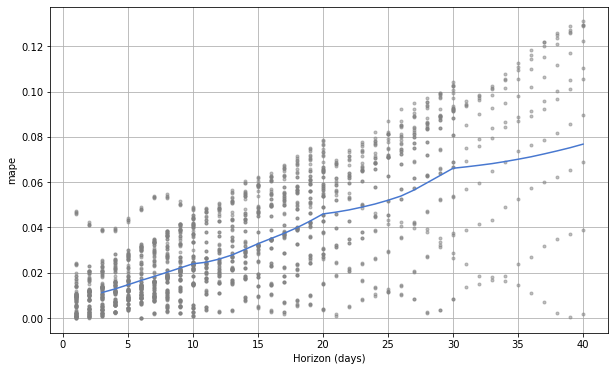

In [41]:
fig_d = plot_cross_validation_metric(df_cv_d, metric='mape')

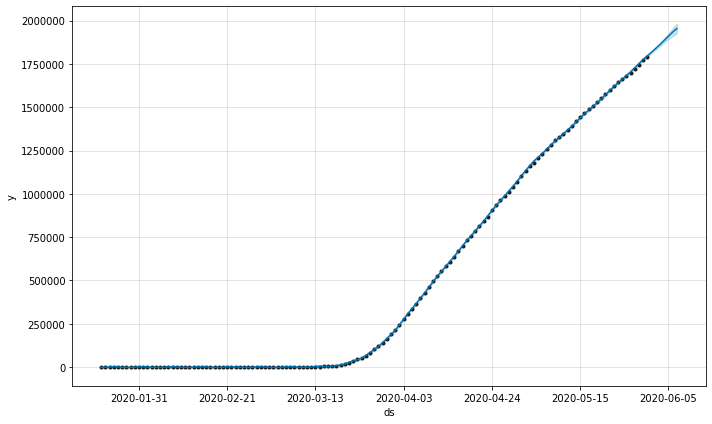

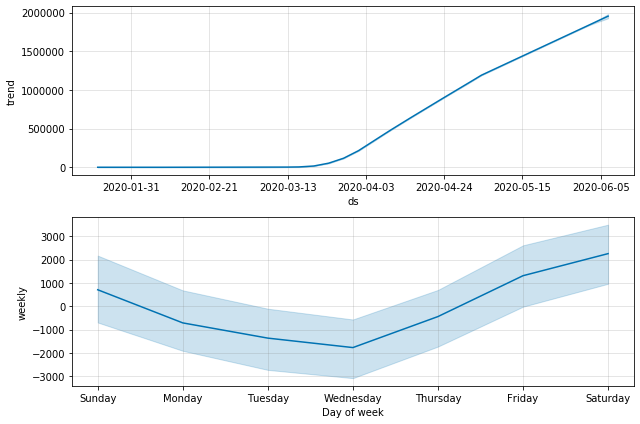

In [42]:
future_d = m.make_future_dataframe(periods=7)
forecast_d = m.predict(future_d)

deaths_forecast_plot = m.plot(forecast_d)
deaths_forecast_plot = m.plot_components(forecast_d)

In [43]:
#fit recovered data, cross validation -- takes a long time

recovered.columns =['ds','y']
m = Prophet(mcmc_samples=10, growth='linear', interval_width=0.95)
m.fit(confirmed, control={'max_treedepth': 20})

# Compute cross-validation y and yhat for the range of horizons in the figure
df_cv_r = pd.DataFrame()
for h in [10, 20, 30, 40]:
    df_cv_h = cross_validation(m, horizon=pd.to_timedelta(h,unit="D"), period='1 days', initial=pd.to_timedelta(80,unit="D"))
    df_cv_h['horizon'] = h
    df_cv_r = pd.concat((df_cv_r, df_cv_h))

# Compute absolute percent error for each prediction
df_cv_r['mape'] = np.abs((df_cv_r['y'] - df_cv_r['yhat']) / df_cv_r['y'])
# mean absolute percent error, by horizon
mape = df_cv_r.groupby('horizon', as_index=False).aggregate({'mape': 'mean'})
mape


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 41 forecasts with cutoffs between 2020-04-11 00:00:00 and 2020-05-21 00:00:00
INFO:fbprophet:Making 31 forecasts with cutoffs between 2020-04-11 00:00:00 and 2020-05-11 00:00:00
INFO:fbprophet:Making 21 forecasts with cutoffs between 2020-04-11 00:00:00 and 2020-05-01 00:00:00
INFO:fbprophet:Making 11 forecasts with cutoffs between 2020-04-11 00:00:00 and 2020-04-21 00:00:00


,horizon,mape
0,10,0.347901
1,20,0.395965
2,30,0.487388
3,40,0.546228


In [44]:
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

df_p_r = performance_metrics(df_cv_r)
df_p_r.head()



,horizon,mse,rmse,mae,mape,mdape,coverage
0,3 days,1.271166e+11,356534.124807,348044.652340,0.368502,0.369001,0.956777
1,4 days,1.426243e+11,377656.263127,368444.095793,0.379019,0.375469,0.952106
2,5 days,1.575155e+11,396882.207976,387466.903435,0.388742,0.387352,0.951832
3,6 days,1.641533e+11,405158.369175,395805.048234,0.387168,0.393076,0.923443
4,7 days,1.780484e+11,421957.845002,411822.393399,0.392171,0.396743,0.880403


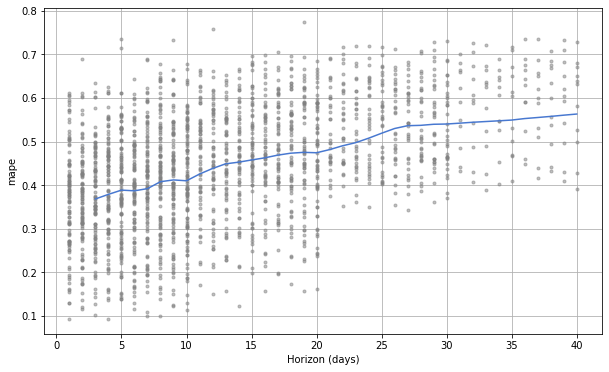

In [45]:
fig_r = plot_cross_validation_metric(df_cv_r, metric='mape')

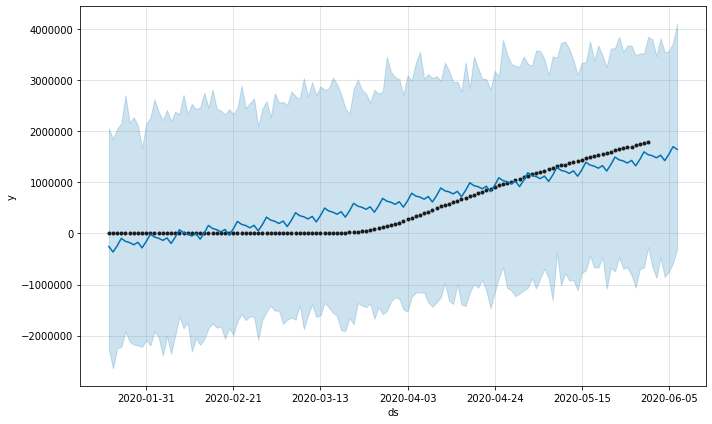

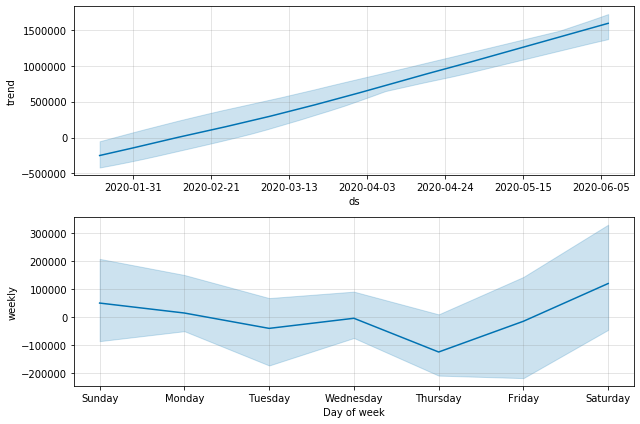

In [46]:
future_r = m.make_future_dataframe(periods=7)
forecast_r = m.predict(future_r)

recovered_forecast_plot = m.plot(forecast_r)
recovered_forecast_plot = m.plot_components(forecast_r)